In [24]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import addict
import copy
import warnings
import scipy
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import matplotlib
import cm_xml_to_matplotlib as make_cmap

import celeri

plt.rcParams["text.usetex"] = False


In [26]:
# Utility functions
n_grid_x = 100
n_grid_y = 100


def inpolygon(xq, yq, xv, yv):
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = matplotlib.path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


def rbf_interpolate(fill_value):
    # Observation coordinates and data
    x_vec = np.linspace(231, 239, n_grid_x)
    y_vec = np.linspace(38, 52, n_grid_y)
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    y_mat = y_mat
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    centroids_val = fill_value

    # Package for RBFInterpolator
    xgrid = np.stack((x_mat, y_mat))
    xflat = xgrid.reshape(2, -1).T
    xobs = np.vstack((centroids_lon, centroids_lat)).T
    yobs = centroids_val
    yflat = scipy.interpolate.RBFInterpolator(
        xobs, yobs, kernel="cubic", smoothing=0.01, epsilon=1.5
    )(xflat)
    ygrid = yflat.reshape(n_grid_x, n_grid_y)
    return xgrid, ygrid


In [27]:
COMMAND_FILE_NAME = "../data/command/western_north_america_command.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)


2022-09-02 16:16:48.272 | INFO     | celeri.celeri:get_logger:122 - Read: ../data/command/western_north_america_command.json
2022-09-02 16:16:48.272 | INFO     | celeri.celeri:get_logger:123 - RUN_NAME: 2022-09-02-16-16-48
2022-09-02 16:16:48.273 | INFO     | celeri.celeri:get_logger:124 - Write log file: ../runs/2022-09-02-16-16-48/2022-09-02-16-16-48.log
2022-09-02 16:16:48.273 | INFO     | celeri.celeri:read_data:129 - Reading data files
2022-09-02 16:16:48.277 | SUCCESS  | celeri.celeri:read_data:133 - Read: ../data/segment/western_north_america_segment.csv
2022-09-02 16:16:48.279 | SUCCESS  | celeri.celeri:read_data:138 - Read: ../data/block/western_north_america_block.csv
2022-09-02 16:16:48.279 | SUCCESS  | celeri.celeri:read_data:145 - Read: ../data/mesh/western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

2022-09-02 16:16:48.303 | SUCCESS  | celeri.celeri:read_data:265 - Read: ../data/mesh/cascadia.msh
2022-09-02 16:16:48.308 | SUCCESS  | celeri.celeri:read_data:301 - Read: ../data/station/western_north_america_station.csv
2022-09-02 16:16:48.309 | INFO     | celeri.celeri:read_data:316 - No mogi_file_name
2022-09-02 16:16:48.311 | INFO     | celeri.celeri:read_data:338 - No sar_file_name


In [28]:
# Calculate Cartesian distances between triangle centroids
centroid_coordinates = np.array([meshes[0].x_centroid, meshes[0].y_centroid, meshes[0].y_centroid]).T
distance_matrix = scipy.spatial.distance.cdist(centroid_coordinates, centroid_coordinates, "euclidean")
# distance_matrix = distance_matrix - np.min(distance_matrix)
# distance_matrix = distance_matrix / np.max(distance_matrix)
distance_matrix = distance_matrix - np.min(distance_matrix) / np.ptp(distance_matrix)


# Calculate correlation matrix
correlation_matrix = np.exp(-distance_matrix)

# Calculate sorted eigenvectors
%time eigenvalues, eigenvectors = np.linalg.eig(correlation_matrix)
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)
ordered_index = np.flip(np.argsort(eigenvalues))
eigenvalues = eigenvalues[ordered_index]
eigenvectors = eigenvectors[:, ordered_index]

# TODO Try returning only the needed subset of eigenvalues
# # https://stackoverflow.com/questions/12167654/fastest-way-to-compute-k-largest-eigenvalues-and-corresponding-eigenvectors-with
n_eigenvalues = meshes[0].n_tde
n_eigenvalues = 100
eigenvalues_small = eigenvalues[0:n_eigenvalues]
eigenvectors_small = eigenvectors[:, 0:n_eigenvalues]

%time eigenvalues, eigenvectors = scipy.linalg.eigh(correlation_matrix, subset_by_index=[meshes[0].n_tde - n_eigenvalues, meshes[0].n_tde - 1])

eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)
ordered_index = np.flip(np.argsort(eigenvalues))
eigenvalues = eigenvalues[ordered_index]
eigenvectors = eigenvectors[:, ordered_index]



CPU times: user 1.65 s, sys: 128 ms, total: 1.78 s
Wall time: 228 ms
CPU times: user 3.6 s, sys: 1.49 s, total: 5.09 s
Wall time: 1.38 s


In [29]:
def interpolate_and_plot(fill_value):
    # Interpolate values onto a regular grid for plotting
    xgrid, ygrid = rbf_interpolate(fill_value)
    xflat = xgrid.reshape(2, -1).T
    inpolygon_vals = inpolygon(
        xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
    ygrid[~inpolygon_vals] = np.nan

    # Plot
    levels = np.linspace(-1.0, 1.0, 6)
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore", message="No contour levels were found within the data range."
        )
        plt.contourf(*xgrid, ygrid, cmap=cmap, levels=levels, extend="both")
        plt.contour(
            *xgrid,
            ygrid,
            colors="k",
            linestyles="solid",
            linewidths=0.25,
            levels=levels,
        )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xticks([])
    plt.yticks([])


# # Plot select eigenmodes
# plt.figure(figsize=(16, 13))
cmap = make_cmap.make_cmap("w_ymiddle1.xml")
# # cmap = cmap.reversed()
# for i in range(0, 18):
#     ax = plt.subplot(3, 6, i + 1)

#     # Shift eigenmodes by plotting row to show some dynamic range
#     if i > 5 and i <= 11:
#         i = i - 6 + 20
#     elif i > 11:
#         i = i - 12 + 50
#     fill_value = fill_value = eigenvectors[:, i]

#     # Normalize fill_value for interpretable plotting
#     min_value = np.min(fill_value)
#     max_value = np.max(fill_value)
#     if np.abs(max_value) > np.abs(min_value):
#         fill_value = fill_value / max_value
#     else:
#         fill_value = fill_value / np.abs(min_value)

#     if i == 0 and np.nanmean(fill_value) < 0:
#         fill_value = -1 * fill_value

#     interpolate_and_plot(fill_value)
#     plt.title(f"mode {i}")

# plt.savefig("select_eigenmodes.pdf")
# plt.savefig("select_eigenmodes.png", dpi=500)
# plt.show()


In [30]:
def get_synthetic_displacements(mesh, tri_linear_operator):
    """
    Prescribe dip-slip in a Gaussian pattern
    """
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - np.mean(mesh.centroids[:, 0])
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - np.mean(mesh.centroids[:, 1])

    # Hardcoded northern Cascadia example that Jack suggested.
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - 234.5
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - 48.5

    # Southern Cascadia example
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - np.mean(mesh.centroids[:, 0]) - 2
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - np.mean(mesh.centroids[:, 1])

    tri_centroid_to_mesh_centroid_distance = np.sqrt(
        tri_centroid_to_mesh_lon**2 + tri_centroid_to_mesh_lat**2
    )
    dip_slip_distribution = np.exp(
        -((tri_centroid_to_mesh_centroid_distance / 1.0) ** 2.0)
    )
    slip_distribution = np.zeros(2 * dip_slip_distribution.size)
    slip_distribution[1::2] = dip_slip_distribution  # Dip slip only
    slip_distribution[0::2] = 1e-4 * np.random.randn(
        dip_slip_distribution.size
    )  # Adding a teeny amount of non-zero noise here just so contouring works...ugh
    synthetic_displacements = tri_linear_operator @ slip_distribution
    return slip_distribution, synthetic_displacements


def plot_slip_distributions(
    slip_distribution_input, slip_distribution_estimated, suptitle_string
):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.title("input strike-slip")
    interpolate_and_plot(slip_distribution_input[0::2])

    plt.subplot(1, 4, 2)
    plt.title("estimated strike-slip")
    interpolate_and_plot(slip_distribution_estimated[0::2])

    plt.subplot(1, 4, 3)
    plt.title("input dip-slip")
    interpolate_and_plot(slip_distribution_input[1::2])

    plt.subplot(1, 4, 4)
    plt.title("estimated dip-slip")
    interpolate_and_plot(slip_distribution_estimated[1::2])

    plt.suptitle(suptitle_string)
    plt.show()


In [31]:
# operators = addict.Dict()
tde_matrix = celeri.get_tde_to_velocities(meshes, station, command)
# celeri.get_all_mesh_smoothing_matrices(meshes, operators)

# Eliminate matrix entries for vertical displacments and tensile slip
# tde_matrix = copy.deepcopy(operators.tri_station)
tde_matrix = np.delete(tde_matrix, np.arange(2, tde_matrix.shape[0], 3), axis=0)
tde_matrix = np.delete(tde_matrix, np.arange(2, tde_matrix.shape[1], 3), axis=1)

# Generate synthetic slip source and synthetic displacements
slip_distribution, synthetic_displacements = get_synthetic_displacements(
    meshes[0], tde_matrix
)
slip_distribution_strike_slip_true = slip_distribution[0::2]
slip_distribution_dip_slip_true = slip_distribution[1::2]


Calculating cutde partials for triangles: 100%|██████████| 1841/1841 [00:16<00:00, 110.92it/s]


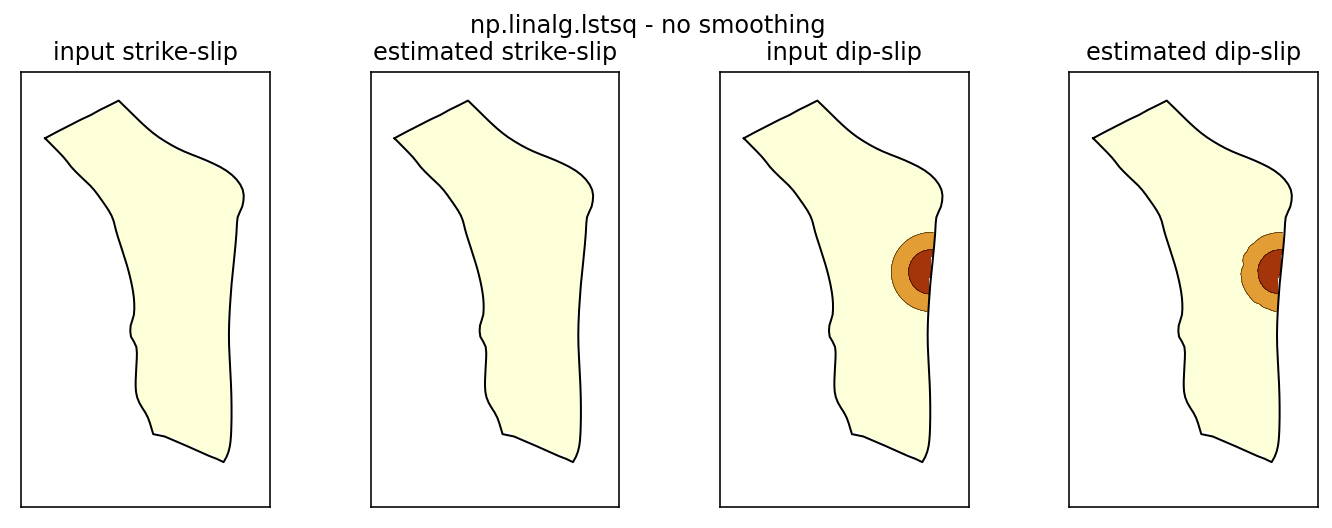

In [32]:
# Direct least squares estimate with no smoothing
slip_distribution_estimated = np.linalg.lstsq(
    tde_matrix, synthetic_displacements, rcond=None
)

plot_slip_distributions(
    slip_distribution,
    slip_distribution_estimated[0],
    suptitle_string="np.linalg.lstsq - no smoothing",
)


eigenvectors.shape=(1841, 100)
tde_matrix.shape=(3372, 3682)
tde_matrix_dip_only.shape=(3372, 1841)


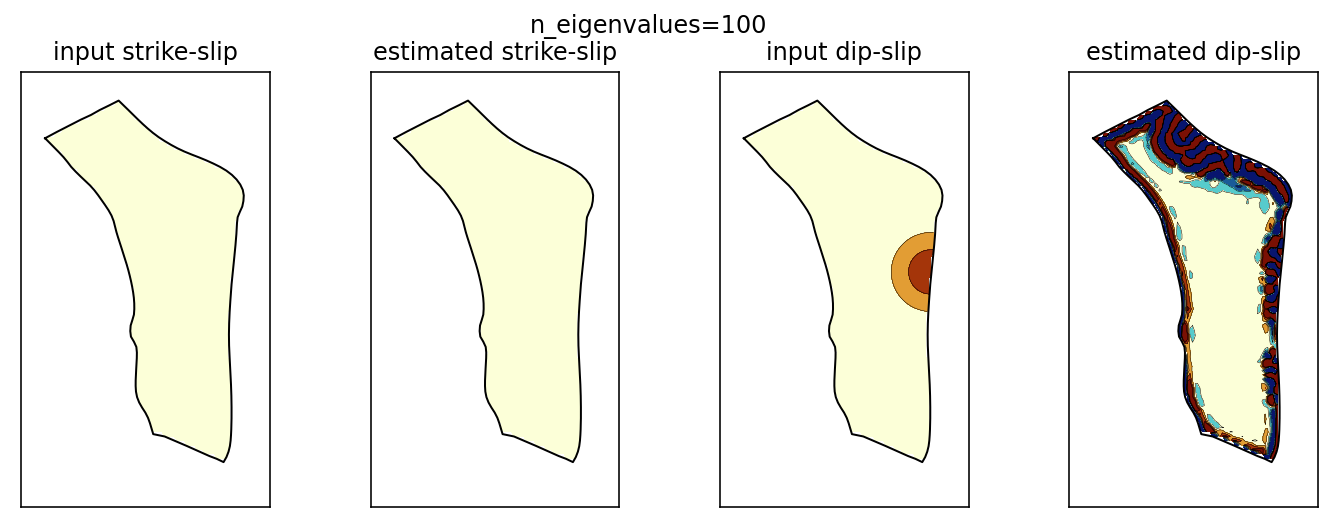

In [33]:
# Eigenvalue slip estimate with dip slip only
# Select dip-slip only
tde_matrix_dip_only = tde_matrix[:, 1::2]

print(f"{eigenvectors.shape=}")
print(f"{tde_matrix.shape=}")
print(f"{tde_matrix_dip_only.shape=}")

# Solve for eigenvector weights
eigenvector_weights_estimated = (
    np.linalg.pinv(tde_matrix_dip_only @ eigenvectors) @ synthetic_displacements
)

# Recover slip from eigenvector weights
slip_distribution_estimated_eigs = (
    eigenvectors @ eigenvector_weights_estimated
)

# Select dip slip only
slip_distribution_eigs = np.zeros(2 * eigenvectors.shape[0])
slip_distribution_eigs[1::2] = slip_distribution_estimated_eigs

plot_slip_distributions(
    slip_distribution,
    slip_distribution_eigs,
    suptitle_string=f"{n_eigenvalues=}",
)

In [34]:
# Eigenvalue slip estimate with dip slip only
# Select dip-slip only

# print(f"{eigenvectors.shape=}")
# print(f"{tde_matrix.shape=}")

# # Solve for eigenvector weights
# eigenvector_weights_estimated = (
#     np.linalg.pinv(tde_matrix @ eigenvectors) @ synthetic_displacements
# )

# # Recover slip from eigenvector weights
# slip_distribution_estimated_eigs = (
#     eigenvectors @ eigenvector_weights_estimated
# )

# # Select dip slip only
# # slip_distribution_eigs = np.zeros(2 * eigenvectors.shape[0])
# slip_distribution_eigs = slip_distribution_estimated_eigs

# plot_slip_distributions(
#     slip_distribution,
#     slip_distribution_eigs,
#     suptitle_string=f"{n_eigenvalues=}",
# )

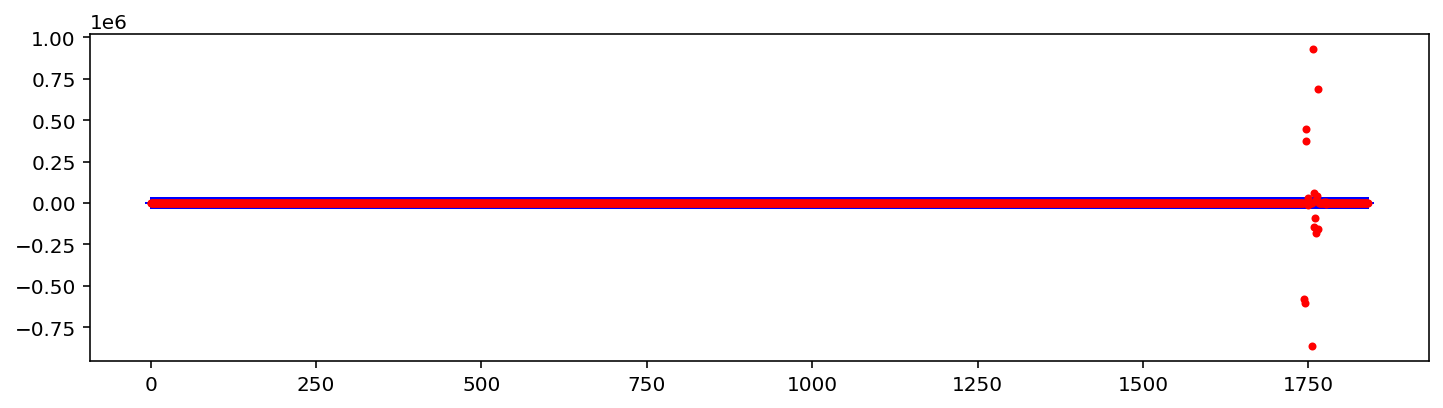

In [35]:
plt.figure(figsize=(12, 3))
plt.plot(slip_distribution_estimated[0][1::2], "b+")
plt.plot(slip_distribution_eigs[1::2], "r.")
plt.show()
